<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Code-setup" data-toc-modified-id="Code-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Code setup</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Read-in-ENM-data" data-toc-modified-id="Read-in-ENM-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read in ENM data</a></span></li><li><span><a href="#ENM-data-frames" data-toc-modified-id="ENM-data-frames-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ENM data frames</a></span></li><li><span><a href="#ENM-WF-bins" data-toc-modified-id="ENM-WF-bins-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>ENM WF bins</a></span></li></ul></li><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pre-processing</a></span><ul class="toc-item"><li><span><a href="#Data-distributions" data-toc-modified-id="Data-distributions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data distributions</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Hierarchical-Agglomerative-Clustering-(HAC)" data-toc-modified-id="Hierarchical-Agglomerative-Clustering-(HAC)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Hierarchical Agglomerative Clustering (HAC)</a></span><ul class="toc-item"><li><span><a href="#Similarity-heatmap" data-toc-modified-id="Similarity-heatmap-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Similarity heatmap</a></span></li><li><span><a href="#Dendrograms-and-elbow-graph" data-toc-modified-id="Dendrograms-and-elbow-graph-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Dendrograms and elbow graph</a></span></li><li><span><a href="#Helper-class-for-selecting-best-ENM-estimator" data-toc-modified-id="Helper-class-for-selecting-best-ENM-estimator-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Helper class for selecting best ENM estimator</a></span></li><li><span><a href="#Gridsearch-to-select-n_clusters" data-toc-modified-id="Gridsearch-to-select-n_clusters-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Gridsearch to select n_clusters</a></span></li><li><span><a href="#Apply-feature-agglomeration" data-toc-modified-id="Apply-feature-agglomeration-3.3.5"><span class="toc-item-num">3.3.5&nbsp;&nbsp;</span>Apply feature agglomeration</a></span></li><li><span><a href="#Concatenate-final-dataframe" data-toc-modified-id="Concatenate-final-dataframe-3.3.6"><span class="toc-item-num">3.3.6&nbsp;&nbsp;</span>Concatenate final dataframe</a></span></li></ul></li></ul></li><li><span><a href="#Preliminary-models" data-toc-modified-id="Preliminary-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preliminary models</a></span></li></ul></div>

# Code setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# To suppress warning output
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Important imports
import numpy as np
from numpy import random
import pandas as pd
import os, sys

# Set random seed across notebook for repeatable results
np.random.seed(42)

In [2]:
# To plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
plt.rcParams['axes.titlesize'] = 'x-large' #16
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'

In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "figs"

if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory did not exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.')

Figure directory exists.


In [4]:
# Import classes and functions used across multiple notebooks
sys.path.append(os.getcwd())
import importlib
import functions as blt
importlib.reload(blt);

Figure directory exists.
Figure directory exists.


# Data

## Read in ENM data

In [159]:
# Read in engineered nanomaterials (ENM) weight fraction (WF) data ("labels")
y_enm = pd.read_csv("./data/ENM-clean.csv", 
                    sep=',', header='infer', usecols=[4])

# Read in potential predictive variables ("features") for ENM WF
X_enm = pd.read_csv("./data/ENM-clean.csv", 
                    sep=',', header='infer', index_col=0)

Note that each feature either has a prefix, or will be assigned a prefix that indicates what "data group" it belongs under.
* cprp = chemical property
* func = chemical functional use
* pgen = general product category
* pgrp = product groups (a subset of a category)
* mtrx = product matrix property  

After agglomeration, two new prefixes are introduced:
* fagg = aggregated chemical functional uses
* pagg = aggregated product categories

The following code cleans the data and column names.

In [160]:
# Drop unwanted columns
    # For PUC, keeping getcat, group, refined, assigned ("matrix")
    # Drop dehydrating_agent[22], dispersing_agent[24], fuel_agent[27]
X_enm.drop(X_enm.columns[[0,1,2,3,4,9,12,22,24,27,34,35,36]], 
           axis=1, inplace=True)    

# Rename columns
X_enm.columns = X_enm.columns.str.replace('_','')
X_enm.rename(columns = {'gencatID':'pgen', 
                        'group':'pgrp', 
                        'refinedproducttype':'refined', 
                        'assignedID':'mtrx', 
                        'measured':'mtrx_WFmeasured', 
                        'antistainagent':'antiredepositionagent', 
                        'lubricatingagent':'antiadhesivecohesive', 
                        'uvstabilizer':'UVstabilizer'
                       }, inplace=True)

# To maintain atomicity, assign all child-specific products (C) as articles (A) 
# and all OTC pharmaceuticals (P) as formulas (F) (they were all liquids)
X_enm['mtrx'] = X_enm['mtrx'].replace('C','A', regex=True)
X_enm['mtrx'] = X_enm['mtrx'].replace('P','F', regex=True)

# Clean up data in refined column so it's only spray vs NOC
X_enm.loc[X_enm.refined != 'spray', 'refined'] = 'NOC'

# Transform factor data (product categories) into binary columns
X_enm = pd.get_dummies(X_enm, 
                       prefix=["pgen","pgrp","refined","mtrx"], 
                       columns=["pgen","pgrp","refined","mtrx"])

# Remove spaces from column names
X_enm.columns = X_enm.columns.str.replace(' ','')
X_enm.columns = X_enm.columns.str.replace('/','')
X_enm.columns = X_enm.columns.str.replace('-','')
X_enm.columns = X_enm.columns.str.replace('and','')

# Edit column name prefixes and suffixes for consistency and clarity
X_enm.columns = X_enm.columns.str.replace('prop','cprp_')
X_enm.columns = X_enm.columns.str.replace('refined','mtrx')
X_enm.columns = X_enm.columns.str.replace('mtrx_F','mtrx_formulation')

# Drop columns absent from organics
X_enm.drop(['pgen_AP','pgen_CS','pgen_FC','pgen_PH','pgrp_apparel',
            'pgrp_coldrelief','pgrp_firstaid','pgrp_foodstorage',
            'pgrp_largeappliances','pgrp_nutritionalsupplements',
            'pgrp_portableairprocessing','pgrp_toys',
            'mtrx_NOC','mtrx_A'],   # redundant features
           axis=1, inplace=True)

# Rearrange feature order
cols = X_enm.columns.tolist()
cols = cols[:5] + [cols[16]] + cols[5:16] + cols[17:] # Move anti_adh. up
cols = cols[:20] + cols[21:] + [cols[20]]             # WF_measured to end
X_enm = X_enm[cols]

# Add 'func' prefix to functional uses
cols = X_enm.columns
idx_func = np.asarray([i for i, c in enumerate(cols) if not '_' in c])
X_enm.rename(columns={c: '_'.join(('func', c)) for c in cols[idx_func]}, 
                inplace=True)

In [161]:
# Export column headings list
with open('./data/column-headers.txt', 'w') as filehandle:  
    for listitem in cols:
        filehandle.write('%s\n' % listitem)

In [162]:
# Log-transform density so that it is no longer skewed
X_enm['cprp_logdensity'] = X_enm['cprp_Density'].apply(np.log10)

# Replace propDensity with propLogDensity in data frame
cols = X_enm.columns.tolist()
cols = cols[:3] + cols[-1:] + cols[4:-1]
X_enm = X_enm[cols]

## ENM data frames

Split ENM-WF into separate dataframes.

In [157]:
# Data frame for only functional use categories
Xf_enm = X_enm[X_enm.columns[pd.Series(X_enm.columns).str.startswith('func')]]
enm_func_names = [s[5:] for s in list(Xf_enm.columns.values)]

# Only product categories
filter_col = [c for c in X_enm if c.startswith('pgen') or c.startswith('pgrp')]
Xp_enm = X_enm[filter_col]
enm_PUC_names = [s[5:] for s in list(Xp_enm.columns.values)]

# Only chemical properties
Xc_enm = X_enm[X_enm.columns[pd.Series(X_enm.columns).str.startswith('cprp')]]

# Only matrix properties
Xm_enm = X_enm.iloc[:,-3:]
print(Xm_enm.columns.values)

['mtrx_spray' 'mtrx_formulation' 'mtrx_WFmeasured']


Note that 'WFmeasured' is not actually a matrix property; it describes whether the WF was verified with lab analysis or if it was simply claimed by the manufacturer.

## ENM WF bins

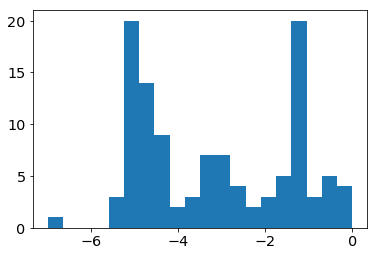

In [149]:
# Log-transformed histogram of weight fraction
plt.hist(np.log10(np.asarray(y_enm)), bins=20);

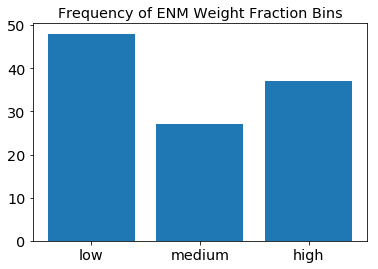

Label bin:  [0 1 2]
Count    :  [48 27 37]
Frequency:  [0.43, 0.24, 0.33]


In [150]:
# Apply bins to ENM and organics data
# (slightly different ranges from those used by Isaacs et al. 2016)
bin_enm = np.asarray(y_enm.apply(blt.bins, axis=1))

# View bar plot of ENM WF bins
blt.bar_graph_bins(bin_enm, data_composition='ENM')

# Pre-processing

## Data distributions

In [172]:
# Function for plotting piecharts
def plot_piechart(data,
                  labels, 
                  save_fig_name):
    my_colors = ["#1f77b4","#ff7f0e","#ffdf00","#d62728","#9467bd",
                 "#2ca02c","#1034A6","#ffbf33","#8B0000",'teal',
                 "#aada30","#e37799","#17becf","#7f7f7f","#cc0099","#0B6623"]
    fig, ax = plt.subplots(figsize=(6,6))
    ax.pie(data, autopct='%1.1f%%', 
           colors=my_colors, 
           labels=labels, 
           pctdistance=0.9, labeldistance=1.05, 
           startangle=90, counterclock=False, 
           textprops={'fontsize':9})
    ax.axis('equal')
    ax.set_title(save_fig_name, weight="bold")
    fig.savefig('./figs/pie_%s.png' 
                % save_fig_name.lower().replace(' ','_'))
    plt.show()

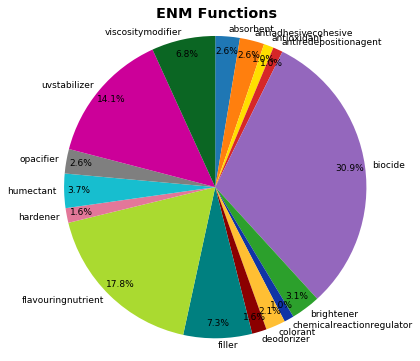

In [173]:
# ENM function breakdown as pie chart
plot_piechart(data=Xf_enm.sum(axis=0), 
              labels=enm_func_names, 
              save_fig_name='ENM Functions')

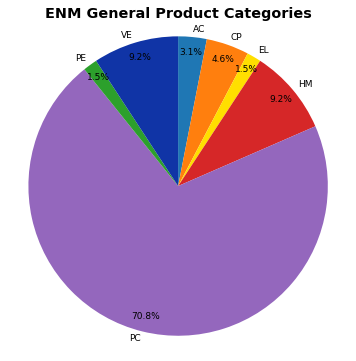

In [174]:
# ENM PUC breakdown as pie chart
plot_piechart(data=Xp_enm.values[:,:7].sum(axis=0), 
              labels=enm_PUC_names[:7], 
              save_fig_name='ENM General Product Categories')

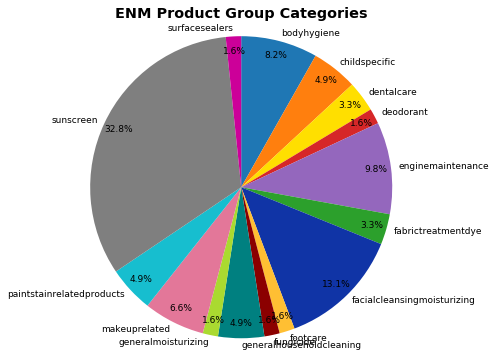

In [175]:
# ENM PUC breakdown as pie chart
plot_piechart(data=Xp_enm.values[:,7:].sum(axis=0), 
              labels=enm_PUC_names[7:], 
              save_fig_name='ENM Product Group Categories')

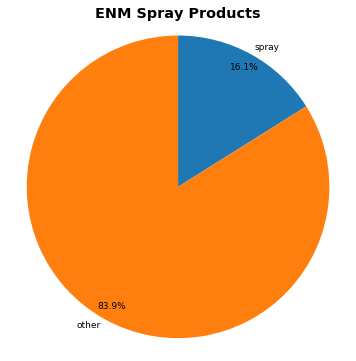

In [178]:
# ENM spray products as pie chart
labels = ['spray','other']
values = [(np.count_nonzero(X_enm['mtrx_spray'])), 
          (len(X_enm['mtrx_spray']) - np.count_nonzero(X_enm['mtrx_spray']))]
plot_piechart(data=values, 
              labels=labels, 
              save_fig_name='ENM Spray Products')

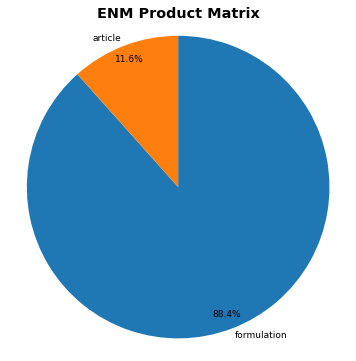

In [179]:
# ENM product matrices as pie chart
labels = ['formulation','article']
pos_labels = np.count_nonzero(X_enm['mtrx_formulation'])
values = [(pos_labels), (len(X_enm['mtrx_formulation']) - pos_labels)]
plot_piechart(data=values, 
              labels=labels, 
              save_fig_name='ENM Product Matrix')

In [180]:
# Shapiro-Wilk Test for normality
from scipy.stats import shapiro

def norm_test(data):
    """
    Source:
    https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
    """
    # Normality test
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # Interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [181]:
norm_test(X_enm['cprp_MP'])

Statistics=0.798, p=0.000
Sample does not look Gaussian (reject H0)


In [182]:
norm_test(X_enm['cprp_BP'])

Statistics=0.756, p=0.000
Sample does not look Gaussian (reject H0)


In [183]:
# Data is non-parametric, so use non-parametric correlation test
from scipy.stats import spearmanr

spearmanr(X_enm['cprp_MP'], X_enm['cprp_BP'])

SpearmanrResult(correlation=0.8767222625090646, pvalue=9.373276989841227e-37)

The high correlation between MP and BP suggests that BP could be dropped. This is supported by the fact that BP is not very relevant for metallic ENM.

## PCA

In [98]:
# Scale the data first (i.e., chemical properties) from 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_enm_scaled = scaler.fit_transform(X_enm)

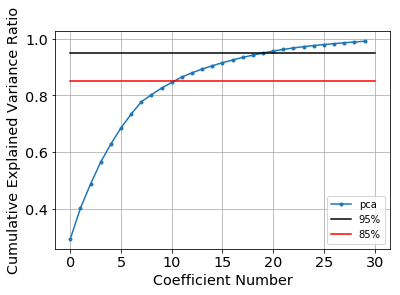

In [99]:
# Figure out number of components to achieve 85% cumulative explained variance
from sklearn import decomposition 
pca=decomposition.PCA(n_components=30)
dim_red_enm=pca.fit(X_enm_scaled)

fig =plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_),'.-',label='pca')
plt.plot([0, 30],[.95,.95],'k',label='95%')
plt.plot([0, 30],[.85,.85],'r',label='85%')
plt.xlabel('Coefficient Number')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid()
plt.legend()
plt.show()

In [100]:
# Transform/apply PCA
from sklearn import decomposition 
pca = decomposition.PCA(n_components=11)
dim_red_enm = pd.DataFrame(pca.fit_transform(X_enm_scaled))

# Export PCA dataframe
dim_red_enm.to_csv("./data/ENM-PCA-feats.csv", sep='\t', na_rep='', 
              header=True, index=True, index_label=None, mode='w')

## Hierarchical Agglomerative Clustering (HAC)

* Feature Agglomeration sklearn http://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html
* Alternate approach
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
* Distance matrix with Jaccard similarity: https://stackoverflow.com/questions/35639571/python-pandas-distance-matrix-using-jaccard-similarity

### Similarity heatmap

In [184]:
# Function for distance matrix, selecting n_clusters
from scipy.spatial.distance import squareform, pdist, cosine, jaccard
from scipy.cluster.hierarchy import dendrogram, linkage

def similarity_heatmap(feature_data, 
                       feature_names, 
                       save_fig_name, 
                       dist_metric='cosine'):
    
    # Transform to find distance between features (not datapoints)
    sim = 1- pdist(feature_data.T, dist_metric)
    
    # Make matrix
    sim_matrix = pd.DataFrame(squareform(sim), 
                               index=feature_names, 
                               columns=feature_names)
    
    # Plot matrix
    from textwrap import wrap
    fig = plt.imshow(sim_matrix)
    plt.title("\n".join(wrap('%s\nSimilarity Matrix of Features (%s)' 
                             % (dist_metric.title(), 
                                save_fig_name.title()), 60)))
    plt.colorbar()
    plt.savefig('./figs/enm_similarmatrix_%s_%s.png' 
                % (save_fig_name, dist_metric))

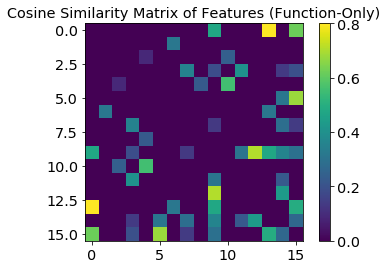

In [185]:
# Similarity matrix: ENM functional use features
similarity_heatmap(Xf_enm, 
                   feature_names=enm_func_names, 
                   save_fig_name='function-only')

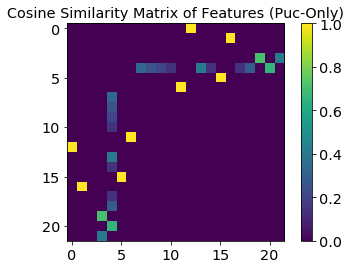

In [186]:
# Similarity matrix: ENM PUC features
similarity_heatmap(Xp_enm, 
                   feature_names=enm_PUC_names, 
                   save_fig_name='PUC-only')

### Dendrograms and elbow graph

Optimize the number of clusters using the elbow method, which estimates the clustering step where the acceleration of distance growth is largest (indicated by the dashed gray line on the dendrogram).

In [187]:
# Define function to visualize best parameter options for clustering
from scipy.spatial.distance import pdist, cosine
from scipy.cluster.hierarchy import dendrogram, linkage

def optimize_clustering(feature_data,
                        feature_names,
                        save_fig_name):
    
    # Calculate cosine distance and features to be clustered 
    # Z-array has format [idx1, idx2, dist, sample_count]
    Z = linkage((feature_data.T), method='average', metric='cosine')
    
    # Calculations for elbow graph
    last = Z[-len(Z):, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    acceleration = np.diff(last, 2)  # 2nd derivative of the distances
    acceleration_rev = acceleration[::-1]
    
    # Find the 5 best contenders for optimal n_clusters
    n = acceleration_rev.argmax() + 2  # if idx 0 is the max, want 2 clusters
    top_n_clusters = acceleration_rev.argsort()[::-1][:3] + 2
    
    # Calculate best clustering threshold for dendrogram
    cutoff_idx = len(feature_data.T) - n - 1
    cutoff_dist = Z[cutoff_idx,2]
    
    # Report optimal n_clusters with Elbow Method
    plt.plot(idxs, last_rev, label='distance')
    plt.plot(idxs[:-2] + 1, acceleration_rev, label='acceleration')
    plt.title('Elbow Method to Determine n_clusters for %s Features' 
              % save_fig_name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
    plt.savefig('./figs/enm_elbow_%s.png' % save_fig_name)
    plt.show()

    print("Optimal(?) n_clusters:", n)   
    print("Contending n_clusters:", top_n_clusters)
    
    # Plot and save dendrogram
    fig=plt.figure(figsize=(30, 15))
    plt.title('Hierarchical Clustering Dendrogram (%s)' % save_fig_name)
    plt.xlabel('Feature Index')
    plt.ylabel('Distance')
    dendrogram(Z,
               leaf_rotation=90.,   # rotates the x axis labels
               leaf_font_size=14.,  # font size for the x axis labels
               labels=feature_names)
    plt.axhline(y=cutoff_dist, color='gray', linestyle='--',
               label="cluster threshold")
    plt.show()
    fig.savefig('./figs/enm_cluster_dendrogram_%s' % save_fig_name, 
                bbox_inches = 'tight')
    
    return top_n_clusters

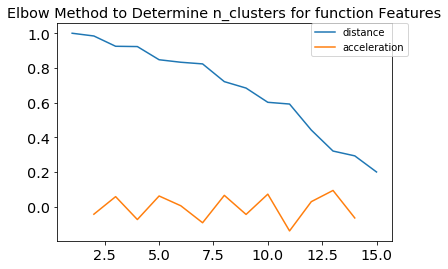

Optimal(?) n_clusters: 13
Contending n_clusters: [13 10  8]


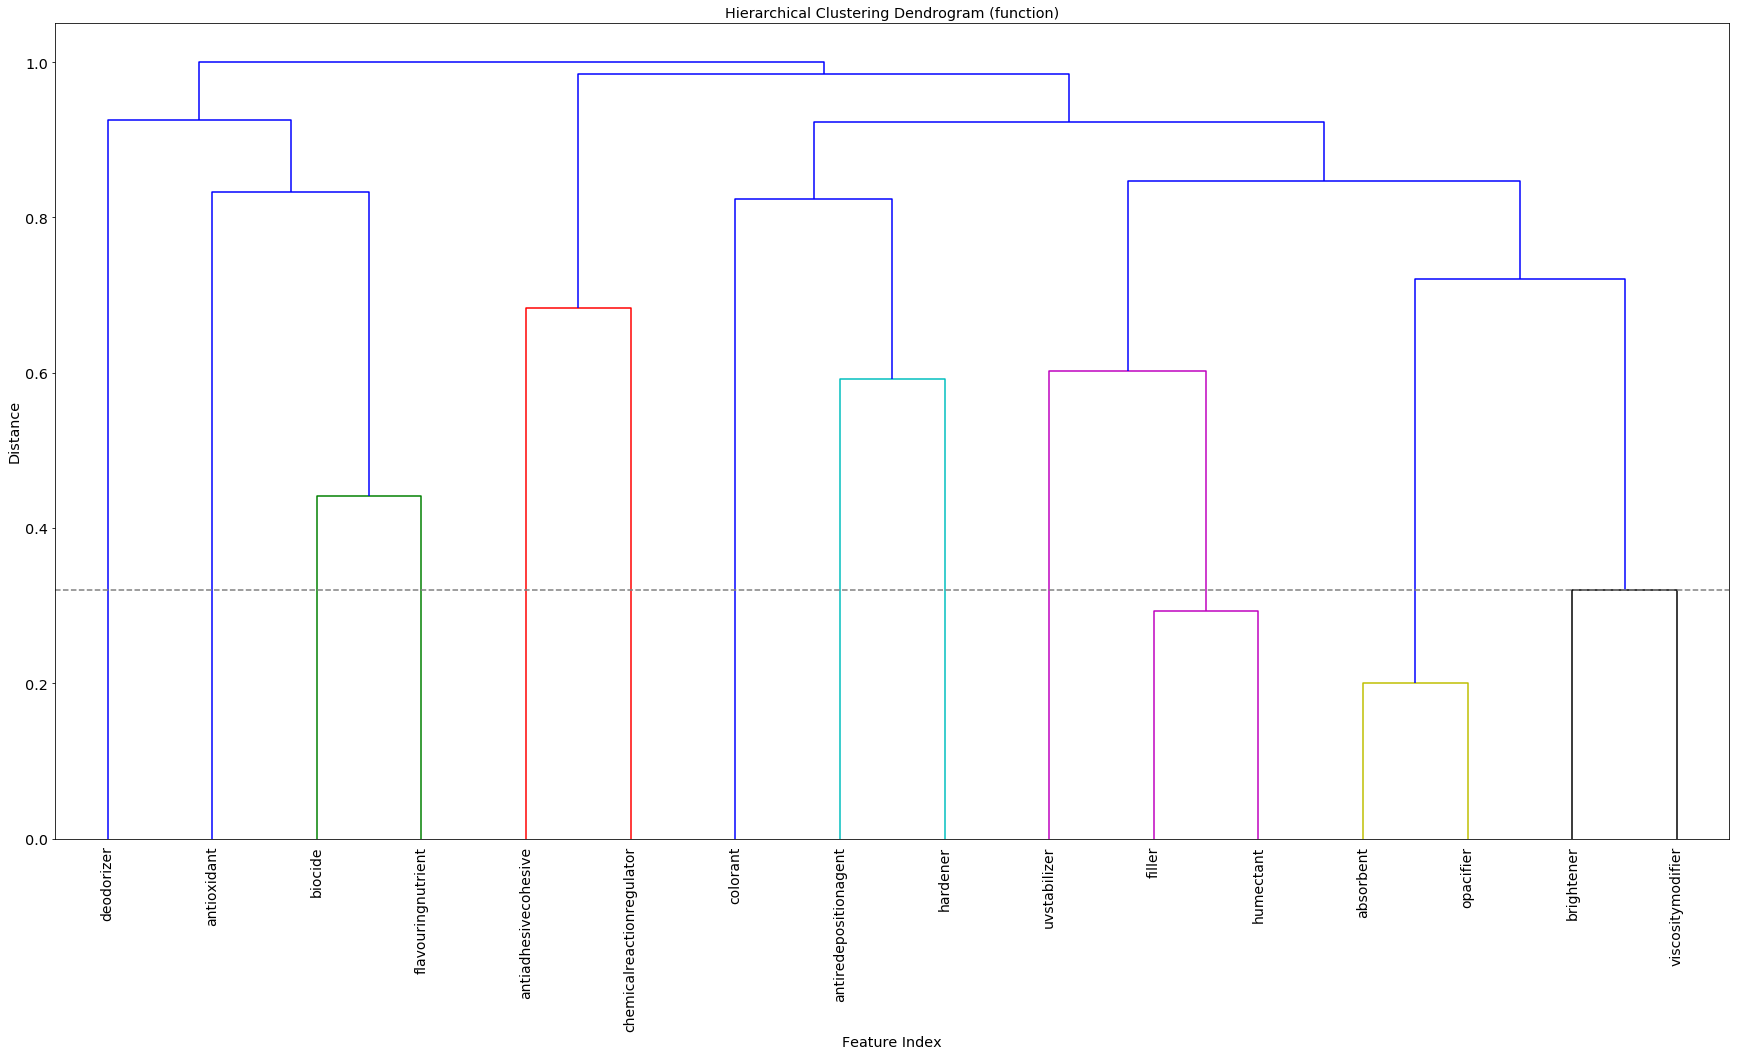

In [188]:
# Elbow graph and dendrogram: ENM functional use features
cluster_set_f = optimize_clustering(Xf_enm, 
                                    feature_names=enm_func_names, 
                                    save_fig_name='function')

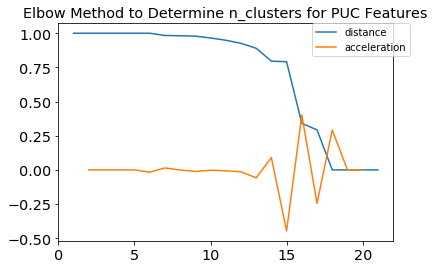

Optimal(?) n_clusters: 16
Contending n_clusters: [16 18 14]


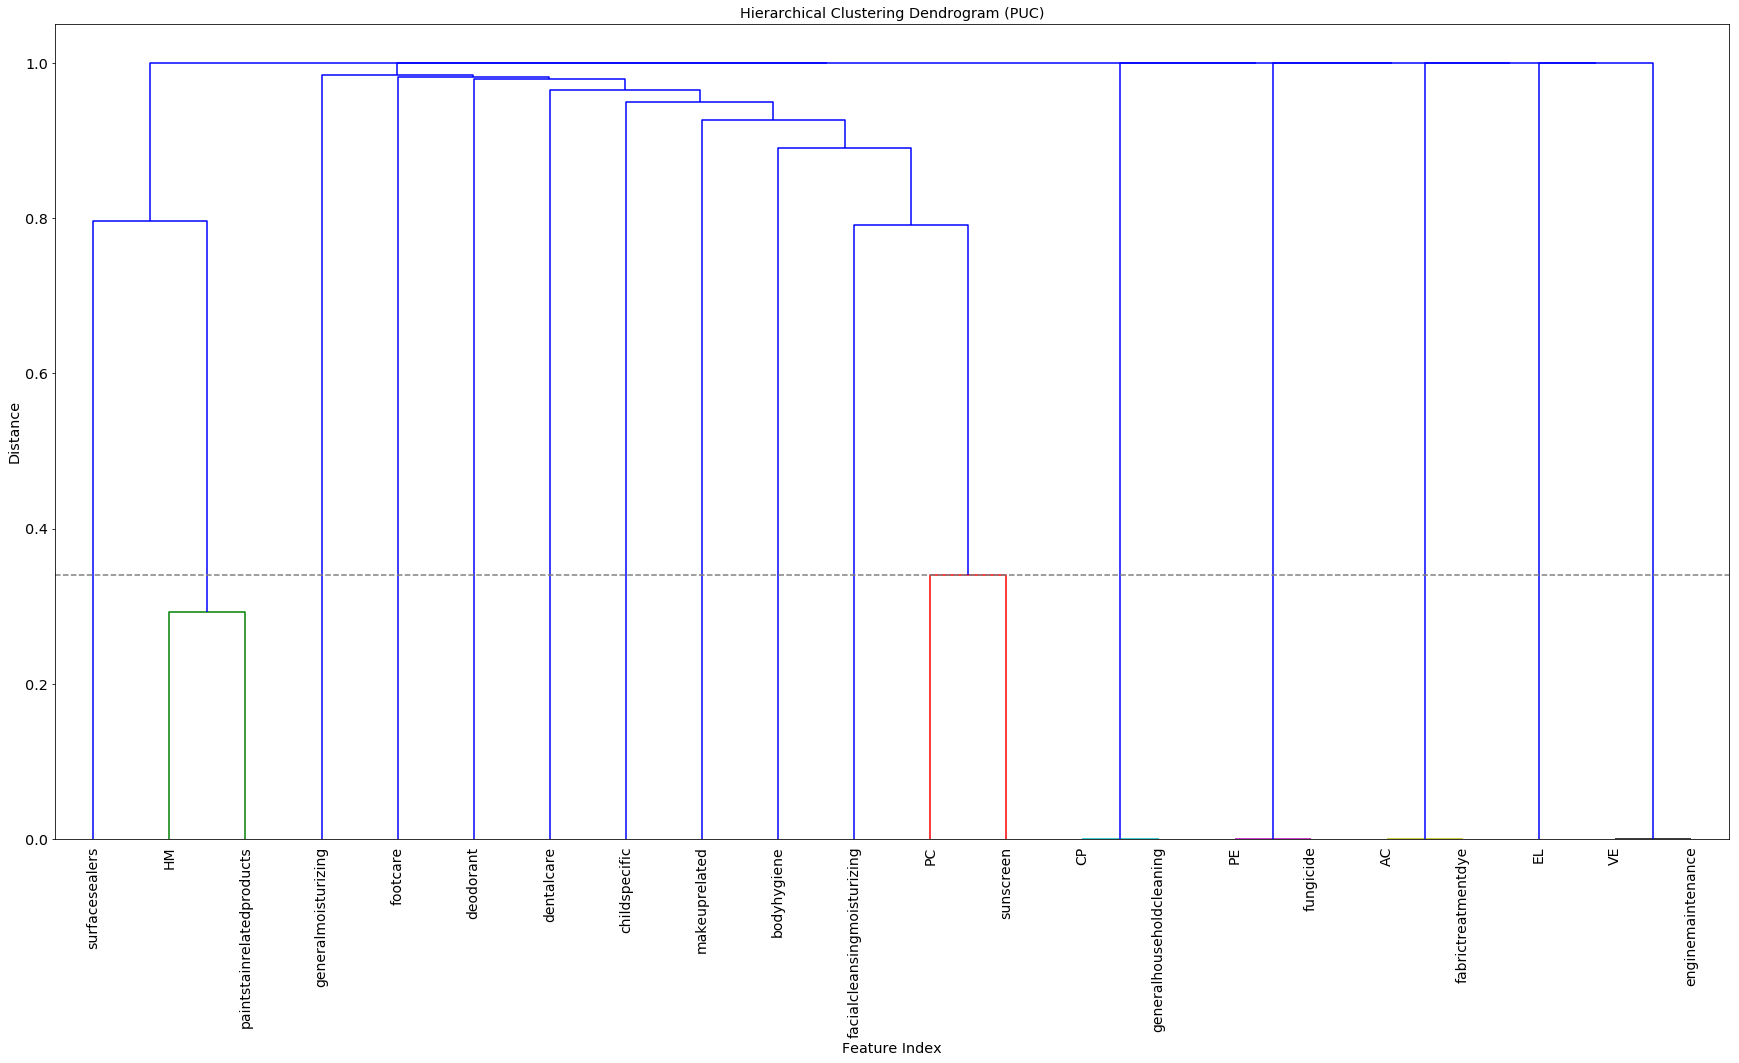

In [189]:
# Elbow graph and dendrogram: ENM PUC features
cluster_set_p = optimize_clustering(Xp_enm, 
                                    feature_names=enm_PUC_names, 
                                    save_fig_name='PUC')

### Helper class for selecting best ENM estimator

In [129]:
# Define sets of models and their respective parameters to compare
# The first dictionary contains the models to be scored
# while the second contains the parameters for each model

from sklearn.cluster import FeatureAgglomeration
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

models = {
    'RFC': RandomForestClassifier(class_weight='balanced'),
    'SVC': SVC(class_weight='balanced')
}
params = {
    'RFC': {'max_depth': [2,4,6,8]},
    'SVC': [{'kernel': ['linear'], 
             'C': np.logspace(-1,7,9)},
            {'kernel': ['rbf'], 
             'C': np.logspace(-1,7,9), 
             'gamma': np.logspace(-7,1,9)},
           ]
}

In [131]:
# Fit gridsearch models to select best estimator based on accuracy
helper = blt.EstimatorSelectionHelper(models, params)
helper.fit(Xf_enm, bin_enm, n_jobs=3)
helper.score_summary(sort_by='mean_score')

Running GridSearchCV for RFC.
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for SVC.
Fitting 10 folds for each of 90 candidates, totalling 900 fits
RFC
SVC


[Parallel(n_jobs=3)]: Done 900 out of 900 | elapsed:  1.8min finished


,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,max_depth
4,SVC,0.416667,0.688333,0.8,0.11316,0.1,NaN,linear,NaN
76,SVC,0.416667,0.655,0.8,0.12053,1e+06,1e-07,rbf,NaN
20,SVC,0.416667,0.651667,0.777778,0.108242,0.1,1,rbf,NaN
28,SVC,0.416667,0.646667,0.8,0.122303,1,0.1,rbf,NaN
0,RFC,0.0833333,0.638333,0.8,0.200623,NaN,NaN,NaN,2
35,SVC,0.2,0.636667,0.777778,0.170007,10,0.001,rbf,NaN
59,SVC,0.2,0.636667,0.777778,0.170007,10000,1e-06,rbf,NaN
68,SVC,0.333333,0.624444,0.8,0.15314,100000,1e-06,rbf,NaN
36,SVC,0.333333,0.624444,0.8,0.15314,10,0.01,rbf,NaN
60,SVC,0.333333,0.624444,0.8,0.15314,10000,1e-05,rbf,NaN


In [132]:
# Fit gridsearch models to select best estimator based on accuracy
helper = blt.EstimatorSelectionHelper(models, params)
helper.fit(Xp_enm, bin_enm, n_jobs=3)
helper.score_summary(sort_by='mean_score')

Running GridSearchCV for RFC.
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for SVC.
Fitting 10 folds for each of 90 candidates, totalling 900 fits
RFC
SVC


[Parallel(n_jobs=3)]: Done 900 out of 900 | elapsed:    1.7s finished


,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,max_depth
3,RFC,0.333333,0.672778,0.833333,0.141627,NaN,NaN,NaN,8
93,SVC,0.333333,0.655,0.833333,0.1644,1e+07,10,rbf,NaN
84,SVC,0.333333,0.655,0.833333,0.1644,1e+06,10,rbf,NaN
75,SVC,0.333333,0.655,0.833333,0.1644,100000,10,rbf,NaN
66,SVC,0.333333,0.655,0.833333,0.1644,10000,10,rbf,NaN
57,SVC,0.333333,0.655,0.833333,0.1644,1000,10,rbf,NaN
48,SVC,0.333333,0.655,0.833333,0.1644,100,10,rbf,NaN
39,SVC,0.333333,0.655,0.833333,0.1644,10,10,rbf,NaN
38,SVC,0.333333,0.645,0.833333,0.144433,10,1,rbf,NaN
92,SVC,0.333333,0.645,0.833333,0.144433,1e+07,1,rbf,NaN


The best performing classifier was variable. We decided to use the SVC-RBF in subsequent pre-processing steps.

### Gridsearch to select n_clusters

The top few n_clusters found using elbow graphs in addition to the maximum number of clusters (i.e., no agglomeration), are evaluated using an SVC-RBF (supervised learning) to determine the final n_clusters. This is done using a gridsearch function.

In [190]:
# TODO: breaks on contour plot when search includes third parameter

# Define function to optimize and perform SVC-RBF with accuracy scoring
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import FeatureAgglomeration
from sklearn.svm import SVC
from sklearn.svm import SVR
import random

def gridsearch_svm(X_training, 
                   y_training, 
                   n_clusters_set=None, 
                   c_set=np.logspace(-1,7,17), 
                   gamma_set=np.logspace(-7,1,17)):
    """
    This function searches the specified grid of C and gamma values for the 
    optimal parameter values with which to run SVC-RBF, then returns the best 
    values based on validation accuracy. 
    
    Parameters
    ----------
    n_clusters_set: array of int (default=None)
        Includes feature agglomeration in pipeline using the specified array 
        of cluster numbers to try out 
    """ 
    
    # Define pipelines and parameters for the grid search
    seed = 42
    if isinstance(y_training[0], float):
        estimator = SVR(kernel='rbf', random_state=seed)
        scoring = 'explained_variance'
    else:
        estimator = SVC(kernel='rbf', 
                        class_weight='balanced', 
                        random_state=seed)
        scoring = 'balanced_accuracy'
    if np.all(n_clusters_set == None):
        prepipe = Pipeline([('scale', MinMaxScaler()), 
                            ('estimator', estimator)
                           ])
        param_grid = {'estimator__C': c_set,
                      'estimator__gamma': gamma_set
                     }
    else:
        agg = FeatureAgglomeration(X_training, 
                                   affinity="cosine", 
                                   linkage="average")
        prepipe = Pipeline([('agg', agg), 
                            ('estimator', estimator)
                           ])
        param_grid = {'agg__n_clusters': n_clusters_set, 
                      'estimator__C': c_set, 
                      'estimator__gamma': gamma_set
                     }

    # Grid search with CV to find best model parameters
    n_jobs = 3
    cv = 10
    grid_search = GridSearchCV(prepipe, 
                               param_grid, 
                               cv=cv, 
                               scoring=scoring, 
                               n_jobs=n_jobs, 
                               pre_dispatch=2*n_jobs)
    grid_search.fit(X_training, y_training)
    C = grid_search.best_params_.get('estimator__C')
    gamma = grid_search.best_params_.get('estimator__gamma')
    print(grid_search.best_params_)
    print('K-fold CV random state: ', seed)
    print('Best fold',grid_search.scoring, ':    ',grid_search.best_score_)
    
    return C, gamma

Have to run fit with [X + a very small number] so that features with very few ones don't go missing during cross validation. https://stats.stackexchange.com/questions/324732/kernel-density-estimator-kde-with-too-many-zeroes-as-input

In [191]:
# Function features only
gridsearch_svm(Xf_enm+0.0001, 
               bin_enm, 
               n_clusters_set=[16,13,10], 
               c_set=np.logspace(-1,7,9), 
               gamma_set=np.logspace(-7,1,9))

{'agg__n_clusters': 10, 'estimator__C': 1.0, 'estimator__gamma': 1.0}
K-fold CV random state:  42
Best fold balanced_accuracy :     0.6029761904761904


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(1.0, 1.0)

In [173]:
# PUC features only
gridsearch_svm(Xp_enm+0.0001, 
               bin_enm, 
               n_clusters_set=cluster_set_p, 
               c_set=np.logspace(-1,7,9), 
               gamma_set=np.logspace(-7,1,9))

{'agg__n_clusters': 18, 'estimator__C': 10.0, 'estimator__gamma': 10.0}
K-fold CV random state:  42
Best fold balanced_accuracy :     0.5999999999999999


(10.0, 10.0)

### Apply feature agglomeration

We decided to use n_clusters from the elbow graphs, so as not to lose too many functional use groups.

In [193]:
# Apply feature agglomeration to functional use and PUC features
Xf_enm_red = blt.feat_agglom(13, Xf_enm, Xf_enm)
Xp_enm_red = blt.feat_agglom(16, Xp_enm, Xp_enm)

Lastly, eliminate propBP due to redundancy and lack of relevance for much of the ENM data.

In [194]:
# Drop BP
Xc_enm = Xc_enm.drop(['cprp_BP'], axis=1)

### Concatenate final dataframe

In [195]:
# Concatenate all clustered and unscaled features into new dataframe
XX_enm = pd.concat([Xc_enm, Xf_enm_red, Xp_enm_red, Xm_enm], axis=1)
XX_enm.tail(4)

,cprp_MW,cprp_MP,cprp_logdensity,agg_func_absorben_func_opacifier,agg_func_brighten_func_viscositym,agg_func_filler_func_humectant,func_antiadhesivecohesive,func_antioxidant,func_antiredepositionagent,func_biocide,...,pgrp_dentalcare,pgrp_deodorant,pgrp_facialcleansingmoisturizing,pgrp_footcare,pgrp_generalmoisturizing,pgrp_makeuprelated,pgrp_surfacesealers,mtrx_spray,mtrx_formulation,mtrx_WFmeasured
108,107.868,961.78,1.01473,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
109,107.868,961.78,1.01473,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
110,107.868,961.78,1.01473,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0
111,107.868,961.78,1.01473,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


In [196]:
# Export unscaled ENM dataframe
XX_enm.to_csv("./data/ENM-preprocessed-feats.csv", sep='\t', na_rep='', 
              header=True, index=True, index_label=None, mode='w')

In [197]:
# Export ENM PUC features dataframe for performing agglomeration with organics
X_enm.to_csv("./data/ENM-pre-preprocessed-feats.csv", sep='\t', na_rep='', 
              header=True, index=True, index_label=None, mode='w')

# Preliminary models

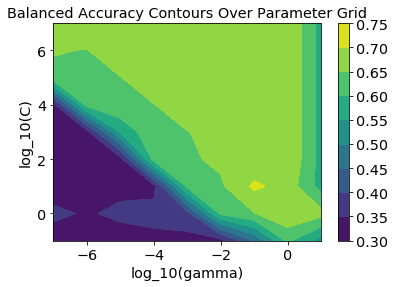

Random state:	 69
Best parameters: {'C': 10.0, 'gamma': 0.1}
Max opt. balanced accuracy: 0.710
Avg. balanced accuracy:     0.708
Normalized Confusion Matrix
[[0.81 0.15 0.04]
 [0.37 0.56 0.07]
 [0.08 0.16 0.76]]


0.7082707707707708

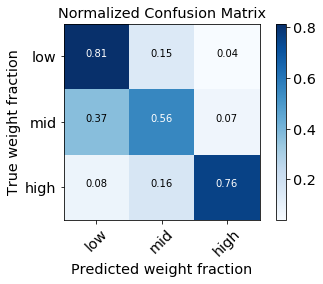

In [198]:
# SVC-RBF on clustered ENM-only data
param_grid = {'estimator__C': np.logspace(-1,7,9), 
              'estimator__gamma': np.logspace(-7,1,9)
             }
blt.model_opt_exe(classifier='svc', 
                  aug_type='none', 
                  k=0, 
                  feat_data=XX_enm+0.0001, 
                  bin_data=bin_enm, 
                  seed=69, 
                  show_opt_plot=True, 
                  show_cnf_matrix=True, 
                  param_grid=param_grid)

In [304]:
# Multiple trials SVC-RBF, balanced accuracy
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': XX_enm, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
blt.multi_trials(num_trials=100, 
                 model_params=model_params, 
                 print_results=True)

Avg accuracy:     0.715
Median accuracy:  0.715
StdDev accuracy:  0.011
Numer of trials:  100
Results:  [0.71, 0.71, 0.72, 0.72, 0.7, 0.71, 0.69, 0.72, 0.71, 0.72, 0.73, 0.72, 0.73, 0.71, 0.71, 0.72, 0.71, 0.73, 0.7, 0.72, 0.72, 0.71, 0.71, 0.71, 0.72, 0.74, 0.73, 0.72, 0.74, 0.68, 0.71, 0.71, 0.71, 0.71, 0.71, 0.73, 0.7, 0.72, 0.7, 0.72, 0.72, 0.72, 0.72, 0.7, 0.7, 0.71, 0.72, 0.73, 0.72, 0.72, 0.7, 0.72, 0.72, 0.7, 0.71, 0.7, 0.73, 0.74, 0.71, 0.71, 0.72, 0.69, 0.71, 0.72, 0.72, 0.7, 0.72, 0.71, 0.71, 0.7, 0.7, 0.71, 0.71, 0.72, 0.72, 0.7, 0.73, 0.71, 0.71, 0.72, 0.72, 0.7, 0.73, 0.73, 0.72, 0.72, 0.7, 0.73, 0.73, 0.7, 0.72, 0.73, 0.71, 0.74, 0.72, 0.73, 0.74, 0.71, 0.72, 0.7]


(0.715, 0.011)